In [2]:
!pip install ppi-python

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ppi_py
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
def build_fit_slr(x,y):
    """
    y_hat = model.predict(x)
    """
    model = LinearRegression()
    model.fit(x,y)
    return model

In [5]:
def build_fit_dt(x,y):
    """
    y_hat = model.predict(x)
    """
    model = DecisionTreeRegressor()
    model.fit(x,y)
    return model

In [6]:
def build_fit_rf(x,y):
    """
    y_hat = model.predict(x)
    """
    model = RandomForestRegressor()
    model.fit(x,y)
    return model

In [7]:
def sample_y_linear(x, m, beta, rho):
    """
    Given a sample of X, we generate Y as a linear function (SLR).
    """

    # compute sigma squared
    #sigma_squared = (beta**2)*gamma*(1.-rho)/rho
    sigma_squared = abs(m)*beta*(1.-(rho**2))/(rho**2)

    # sample noise (e_i)
    sampled_e = np.random.normal(loc=0,
                                 scale=sigma_squared*x,
                                 size=x.shape
                                 )

    # compute y as a linear function of x
    y = m*x + sampled_e

    return y


In [8]:
def sample_gamma_population(alpha,
                            beta,
                            sample_size,
                            m,
                            rho = None
                            ):
    """
    Sample <sample_size> instances, x_i ~ G(alpha, gamma)

    Then creates y_i ~ beta*x_i + e_i,
      where e_i ~ N(0, sigma^2_e*x_i), where
      sigma^2_e = (beta^2)gamma[(1-r^2)/)r^2]
      for rho(x_i, y_i) = r ==> desired correlation
    """

    assert np.any(rho != 0), "rho must be different from 0"

    # sample x
    x = np.random.gamma(alpha, beta, sample_size)

    # sample y
    y = sample_y_linear(x, m, beta, rho)

    return x, y



In [9]:
def f_wesley(xbar_star, ybar_star, x):
    """
    implementation of f, as defined by pdf.
    f(x_i) = \frac{\bar{Y}^{*}}{\bar{X}^{*}}(x_i)
    """
    assert np.any(xbar_star != 0), "xbar_star must be different from 0"

    return ybar_star*x/xbar_star



In [10]:
def ratio_estimator_mean(x_bar_unlabelled, x_bar_labelled, y_bar_labelled):
    """
    As defined in the pdf.
    """
    assert np.any(x_bar_labelled != 0), "x_bar_labelled must be different from 0"
    return x_bar_unlabelled*y_bar_labelled/x_bar_labelled

In [11]:
def ratio_estimator_variance(x_u, x_l, y_l, dof=1):
    """
    as defined from Sampling Theory and Practice (quite complete),
    p97 linearization

    Note, we use 1 degree of freedom for sample variance computation
    """
    # (xbar_tilde**2 / x_bar**2)(1- n/N)(var_y**2, + R^2var_x**2 - 2R*covar(x,y))

    # sample sizes
    x_u = x_u.reshape(1, -1)
    x_l = x_l.reshape(1, -1)
    y_y = y_l.reshape(1, -1)
    n = x_l.shape[1]
    N = x_u.shape[1]

    # means
    mu_x_u = x_u.mean(axis=1)
    x_l_mean = x_l.mean(axis=1)
    y_l_mean = y_l.mean(axis=1)
    r_hat = y_l_mean/x_l_mean

    # variances
    x_sample_var = np.var(x_l, axis=1, ddof=dof)
    y_sample_var = np.var(y_l, axis=1, ddof=dof)
    xy_covar = np.array([np.cov(x_l[i], y_l[i], ddof=dof)[0,1] for i in range(x_l.shape[0])])

    # implement term by term, treat the (1-n/N)*)(1/n) as one term
    term_one = (mu_x_u**2)/(x_l_mean**2)
    term_two = (1.0 - float(n/N))/n
    term_three = y_sample_var**2 + (r_hat**2)*(x_sample_var**2) - 2*r_hat*xy_covar

    variance = term_one*term_two*term_three
    return variance

In [12]:
def mean_absolute_bias(thetas, true_mean):
    """
    For B experimental repeats, computes the mean absolute error (mean bias error)
    across all B experiments.
    """
    errors = thetas - true_mean
    errors = abs(errors)
    errors = errors.reshape(1, -1)
    return np.mean(errors, axis=1)



In [13]:
#################
# constants
#################

# first population
ALPHA_1 = 1.0
GAMMA_1 = 2.0
# second population
ALPHA_2 = 1.4
GAMMA_2 = 1.6


# Y relationship
RHO = 0.4
BETA = 3.2

# data generation sizes
N_TRAIN = 5000
n = 300
N = 10000

# Expected value of X both distributions
EXPECTED_FIRST_DISTRIBUTION_MEAN_X = ALPHA_1*GAMMA_1
EXPECTED_SECOND_DISTRIBUTION_MEAN_X = ALPHA_2*GAMMA_2

# Expected value of Y both distributions (via Wesley formula)
EXPECTED_FIRST_DISTRIBUTION_MEAN_Y = (BETA**3)*(ALPHA_1**2)*(GAMMA_1**2)/(RHO**2)
EXPECTED_SECOND_DISTRIBUTION_MEAN_Y = (BETA**3)*(ALPHA_2**2)*(GAMMA_2**2)/(RHO**2)


print("TRUE MEAN OF 1st X distribution: ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X)
print("TRUE MEAN OF 2nd X distribution: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X)

print("EXPECTED VALUE OF 1ST Y DISTRIBUTION (SIMPLE MULTIPLICATION): ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X*BETA)
print("EXPECTED VALUE OF 2ND Y DISTRIBUTION (SIMPLE MULTIPLICATION): ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)

print("EXPECTED VALUE OF 1ST Y DISTRIBUTION (WESLEY EQUATION): ", EXPECTED_FIRST_DISTRIBUTION_MEAN_Y)
print("EXPECTED VALUE OF 2ND Y DISTRIBUTION (WESLEY EQUATION): ", EXPECTED_SECOND_DISTRIBUTION_MEAN_Y)



# Expected value of Y
EXPECTED_TRUE_MEAN = EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA

TRUE MEAN OF 1st X distribution:  2.0
TRUE MEAN OF 2nd X distribution:  2.2399999999999998
EXPECTED VALUE OF 1ST Y DISTRIBUTION (SIMPLE MULTIPLICATION):  6.4
EXPECTED VALUE OF 2ND Y DISTRIBUTION (SIMPLE MULTIPLICATION):  7.167999999999999
EXPECTED VALUE OF 1ST Y DISTRIBUTION (WESLEY EQUATION):  819.2
EXPECTED VALUE OF 2ND Y DISTRIBUTION (WESLEY EQUATION):  1027.6044800000002


_________________________________
Let's do some playing
________________________________


In [14]:
# generate initial dataset
X_star, Y_star = sample_gamma_population(ALPHA_1,
                                        GAMMA_1,
                                        N_TRAIN,
                                        BETA,
                                        RHO
                                        )
X_star, Y_star = X_star.reshape(1, -1), Y_star.reshape(1, -1)
print("X_star (first distribution) mean: ", X_star.mean(), ", and expected value: ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X)
print("Y_star (first distribution) mean: ", Y_star.mean(), " and expected value: ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X*BETA)

X_star (first distribution) mean:  1.961128126287047 , and expected value:  2.0
Y_star (first distribution) mean:  7.978673495663466  and expected value:  6.4


In [15]:
# generate second dataset, labelled
X_gold, Y_gold = sample_gamma_population(ALPHA_2,
                                        GAMMA_2,
                                        n,
                                        BETA,
                                        RHO
                                        )
X_gold, Y_gold = X_gold.reshape(1, -1), Y_gold.reshape(1, -1)
print("X_labelled (second distribution) mean: ", X_gold.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X)
print("Y_labelled (second distribution) mean: ", Y_gold.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)

X_labelled (second distribution) mean:  2.3072189757254566 , and expected value:  2.2399999999999998
Y_labelled (second distribution) mean:  15.815966339529993 , and expected value:  7.167999999999999


In [16]:
# generate second dataset, unlabelled
X_unlabelled, Y_unlabelled = sample_gamma_population(ALPHA_2,
                                                    GAMMA_2,
                                                    N,
                                                    BETA,
                                                    RHO
                                                    )
X_unlabelled, Y_unlabelled = X_unlabelled.reshape(1, -1), Y_unlabelled.reshape(1, -1)
print("X_Unlabelled (second distribution) mean: ", X_unlabelled.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X)
print("Y_Unlabelled (second distribution) mean: ", Y_unlabelled.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)

X_Unlabelled (second distribution) mean:  2.2717986763801448 , and expected value:  2.2399999999999998
Y_Unlabelled (second distribution) mean:  7.509388724440351 , and expected value:  7.167999999999999


In [17]:
# Using our pre-trained model, let's do inference on X_gold and X_tilde for PPI
Y_labelled_tilde = f_wesley(X_star.mean(), Y_star.mean(), X_gold)
Y_unlabelled_tilde = f_wesley(X_star.mean(), Y_star.mean(), X_unlabelled)

print("f_wesley(X_labelled) (second distribution) mean: ", Y_labelled_tilde.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)
print("f_wesley(X_Unlabelled) (second distribution) mean: ", Y_unlabelled_tilde.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)


f_wesley(X_labelled) (second distribution) mean:  9.386713006439276 , and expected value:  7.167999999999999
f_wesley(X_Unlabelled) (second distribution) mean:  9.242608702489509 , and expected value:  7.167999999999999


In [18]:
# PPI (not PPI++)
Y_gold = Y_gold.squeeze()
Y_labelled_tilde = Y_labelled_tilde.squeeze()
Y_unlabelled_tilde = Y_unlabelled_tilde.squeeze()
theta_ppi = ppi_py.ppi_mean_pointestimate(Y_gold,
                                          Y_labelled_tilde,
                                          Y_unlabelled_tilde,
                                          lhat=1)

print("Theta (PPI) point estimate: ", theta_ppi)

# CI
ci_ppi = ppi_py.ppi_mean_ci(Y_gold,
                            Y_labelled_tilde,
                            Y_unlabelled_tilde,
                            alpha=0.1,
                            alternative='two-sided',
                            lhat=1)

print("Theta_ppi: ", theta_ppi, " with CI: ", ci_ppi, " and width: ", str(ci_ppi[1] -ci_ppi[0]))

Theta (PPI) point estimate:  [15.67186204]
Theta_ppi:  [15.67186204]  with CI:  (array([8.43057233]), array([22.91315174]))  and width:  [14.48257941]


In [19]:
# Ratio estimator
Y_gold = Y_gold.reshape(1, -1)
theta_re = ratio_estimator_mean(X_unlabelled.mean(), X_gold.mean(), Y_gold.mean())

#x_u, x_l, y_l,
re_variance = ratio_estimator_variance(X_unlabelled, X_gold, Y_gold)
print("Ratio estimation: ")
print("Point estimate: ", theta_re, " , variance: ", re_variance)
print("CI: [", theta_re-1.96*np.sqrt(re_variance), ", ", theta_re+1.96*np.sqrt(re_variance), "]")
print("CI width: ",  theta_re+1.96*np.sqrt(re_variance) - (theta_re-1.96*np.sqrt(re_variance)))


Ratio estimation: 
Point estimate:  15.573160490550972  , variance:  [111828.80075581]
CI: [ [-639.86678411] ,  [671.0131051] ]
CI width:  [1310.87988921]


In [20]:
# classic estimator
theta_classic = Y_gold.mean()
print(theta_classic)

variance_classes = Y_gold.var()

print("Classical: ")
print("Point estimate: ", theta_classic, " , variance: ", variance_classes)
print("CI: [", theta_classic-1.96*np.sqrt(variance_classes), ", ", theta_classic+1.96*np.sqrt(variance_classes), "]")
print("CI width: ",  theta_classic+1.96*np.sqrt(variance_classes) - (theta_classic-1.96*np.sqrt(variance_classes)))

15.815966339529993
Classical: 
Point estimate:  15.815966339529993  , variance:  5952.754826169242
CI: [ -135.40606558773834 ,  167.0379982667983 ]
CI width:  302.44406385453664


In [21]:
# errors in bias
classic_errors = mean_absolute_bias(theta_classic, EXPECTED_TRUE_MEAN)
theta_ppi_errors = mean_absolute_bias(theta_ppi, EXPECTED_TRUE_MEAN)
theta_re_errors = mean_absolute_bias(theta_re, EXPECTED_TRUE_MEAN)

print("Classic theta mean bias: ", classic_errors)
print("PPI theta mean bias: ", theta_ppi_errors)
print("RE theta mean bias: ", theta_re_errors)


Classic theta mean bias:  [8.64796634]
PPI theta mean bias:  [8.50386204]
RE theta mean bias:  [8.40516049]


QUestions:


*   non-iid vs iid
*   as the two distributions change progressively, how are iid vs non-iid differ (does performance degrade more or less?)
*   as f degrades (both in terms of 1st distribution and performance on the second 2)
*    Wesley's hypothesis: that the variance of ratio estimator should be close to the diferrence variance (sigma of f - Y) ... it is the variance component from the PPI
*    



RE estimator
- can't just pull the denominator out for variance.... since we have to estimate that, we have a ratio of 2 estimates, and so the variance term must be computed in some manner...

# TODO:
1. Explictly compute the variance components of ppi
2. Compute the mean estimate (and bias) of f on new data, then we can see how well it corrects.
3. Implement an ML function, f (simple non-linear regressor, or even a linear model.
4. How can we degrade f?
5. How can we implement non-IID (different D, what about dependent?)
  - do stratified sampling, and then split them (example, large X values vs small X values in different Unlab/Lab)
6. Pick large N
  - what size N for first population? use 2N?
7. Pick several values of n (exponential from 2 to N)
8. Pick different correlations (1.0,0.7,0.4, 0.1, -0.1, ..., -1.0)
9. Gamma distributions - Covariate shift
  - Fix GAMMA for all distributions (GAMMA = 1)
  - Start with ALPHA_1 = 5
  - we can measure distance (covariate shift) by modulating ALPHA_2 in [0.5, 1.0, 1.5, 2.0, ..., 4.5, 5.0, 5.5, ...., 10.0]
  - Fix BETA = 4.2, or every experiment we randomly sample it around something
  - this experiment tests robustness to distribution drift
  - for results, we can even show all the gamma curves on one plot, have all of them transparent, and have the matplotlib.pyplot alpha=1 for the "current" gamma curve we want to speak to, and on the side show relevant metrics
  - a table showing n vs classic vs ppi vs RE for bias, coverage and CI width
  - wesley also wants to see the variance terms

  10. Gamma distributions - Label drift
    - Now fix GAMMA for all distributions again
    - Start again with ALPHA_1 = 5, BETA = 4.2 for init population
    - Then, we move ALPHA_2 around in [3,4,6,7], so X density changes a bit, but we also modify BETA_2 in [some range of values smaller and larger]
    - Here, we expect the model to be more and more garbage, the past data will hurt
    - report same results

11. RHO
  - right now, this has no effect
  - the real RHO is related to beta....
  - larger (and more negative) BETA is
  - the more noise we add from e_i
  - we


  NOTES:
  - we need to do multiple experiments (highly, little, little negative, highly negative) correlations per bigger experiment (ex. covariate, label drift)
  -


[ 0.5   1.45  2.4   3.35  4.3   5.25  6.2   7.15  8.1   9.05 10.  ]


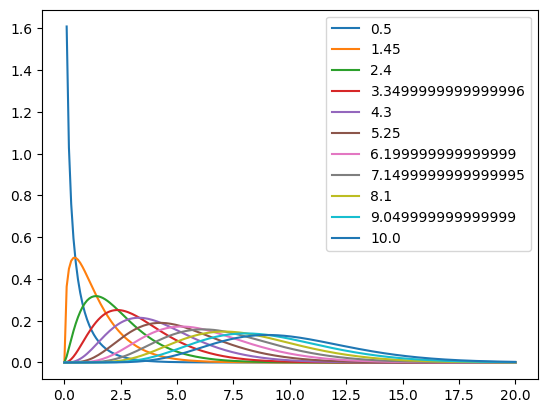

In [22]:
import matplotlib. pyplot as plt
import numpy as np
from scipy. stats import gamma
from sklearn.model_selection import train_test_split

import scipy.stats as stats
from matplotlib import pyplot as plt

alphas = np.linspace(0.5, 10,11)
print(alphas)
x = np.linspace (0, 20, 200)
for alpha in alphas:
    y1 = stats.gamma.pdf(x, a=alpha, scale=1) #a is alpha, loc is beta???
    plt.plot(x, y1, label=str(alpha))
    plt.legend()



In [23]:
# Main script for covariate shift



In [24]:
# Testing and graphs

import pandas as pd

def plot_ci(predictions, lower, upper, true_value=None, categories=None):
    """
    Plots confidence intervals of a predictor. Predictions and widths should be the same type/dimensional array.


    predictions: array of predictions of length l
    lower: array of lower confidence interval estimates of predictions of length l
    upper: array of upper confidence interval estimates of predictions of length l
    true_value (optional): true value of prediction, if available
    categories (optional): list of names of methods
    """
    predictions = np.array(predictions).flatten()
    lower = np.array(lower).flatten()
    upper = np.array(upper).flatten()
    df = {}

    if categories:
        df['method'] = categories
    
    df['lower'] = lower
    df['upper'] = upper

    df = pd.DataFrame(df)

    for lower,upper,y in zip(df['lower'],df['upper'],range(len(df))):
        plt.plot((lower,upper),(y,y),'ro-',color='orange')

    if true_value:
        plt.axvline(x = true_value, ls='--', label = 'True value')
    
    if categories:
        plt.yticks(range(len(df)),list(df['category']))

    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')


/tmp/ipykernel_1528/1176218869.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


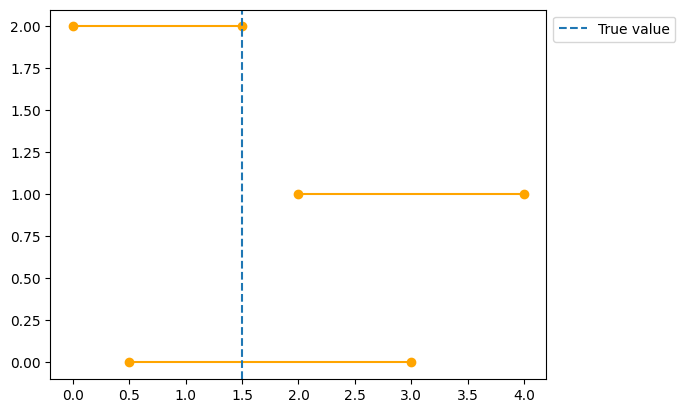

In [25]:
preds = np.array([[2, 3, 1]])
lower = [0.5, 2, 0]
upper = [3, 4, 1.5]

plot_ci(preds, lower, upper, true_value=1.5)

The following is a simple experiment, where we suppose we have two initial gamma distributions, $\mathbb{P}^u = 
\mathbb{P}^\ell$, with certain parameters. We will generate our training set $y = mx + 
\varepsilon$, here we will choose $\varepsilon \sim N(0, \sigma)$ for some small $\sigma$. We will train a model (probabily linear regression), then perform PPI, naive imputation, and classical (TBD what classical will be). We will also sample the true $y$ values, but the ML model will not be able to peek at it. 

Predicted:  [4.13662034] CI:  (array([3.79765212]), array([4.47558856])) Rectifier:  -0.1451974823716707 True mean:  4.0


/tmp/ipykernel_1528/1176218869.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


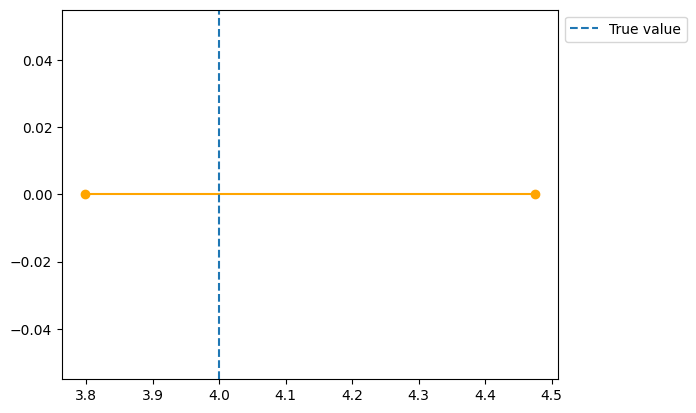

In [26]:
# PPI Testing, experiment 0, single test

import sklearn.model_selection


preds = []
lowers = []
uppers = []
residuals = []

# Generate training set
# Parameters

# Gamma dist, note the parameter names are not usual, k, theta is more usual

alpha = 1.0
beta = 2.0

# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho = 0.9 # 0 < rho <= 1 the smaller the rho, the more noise

# Sampling

x_train, y_train = sample_gamma_population(alpha, beta, train_sample, m, rho)  

x_gold, y_gold = sample_gamma_population(alpha, beta, small_sample, m, rho)

x_ppi, y_ppi = sample_gamma_population(alpha, beta, large_sample, m, rho)

# Reshaping for scikitlearn

x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

model = build_fit_slr(x_train, y_train)  # Training

# Residual testing

y_test_pred = model.predict(x_test)
residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
residuals.append(residual)

y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
y_fitted = model.predict(x_ppi)  # Unlabelled fitted

# Manual rectifier computation
rectifier = np.mean(y_gold_fitted - y_gold)

theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


preds.append(theta)
lowers.append(theta_ci[0])
uppers.append(theta_ci[1])
true_mean = m * alpha * beta


plot_ci(preds, lowers, uppers, true_value=true_mean)

print("Predicted: ", theta, "CI: ", theta_ci, "Rectifier: ", rectifier, "True mean: ", true_mean)

In [27]:
# PPI Testing, experiment 0, multi-test

preds = []
lowers = []
uppers = []
true_bias = []
residuals = []
covered = []

# Generate training set
# Parameters

# Gamma dist, note the parameter names are not usual, k, theta is more usual

alpha = 1.0
beta = 2.0

# Population samples

train_size = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho = 0.9 # 0 < rho <= 1 the smaller the rho, the more noise

# Iterations

n_its = 10000

for i in range(n_its):
    # Sampling

    x_train, y_train = sample_gamma_population(alpha, beta, train_sample, m, rho)  

    x_gold, y_gold = sample_gamma_population(alpha, beta, small_sample, m, rho)

    x_ppi, y_ppi = sample_gamma_population(alpha, beta, large_sample, m, rho)

    # Reshaping for scikitlearn

    x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
    x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
    x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

    model = build_fit_slr(x_train, y_train)  # Training

    # Residual testing

    y_test_pred = model.predict(x_test)
    residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
    residuals.append(residual)

    y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
    y_fitted = model.predict(x_ppi)  # Unlabelled fitted

    # Manual rectifier computation
    rectifier = np.mean(y_gold_fitted - y_gold)
    

    theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
    theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


    preds.append(theta[0])
    lowers.append(theta_ci[0][0])
    uppers.append(theta_ci[1][0])
    true_bias.append(np.mean(y_fitted - y_ppi))
    if true_mean >= theta_ci[0][0] and true_mean <= theta_ci[1][0]:
        covered.append(1)
    else:
        covered.append(0)

print("Average residual: ", np.mean(residuals))
print("Average pred: ", np.mean(preds), "Average lower bound: ", np.mean(lowers), "Average upper bound: ", np.mean(uppers), "Covered percent: ", np.mean(covered))

Average residual:  2.651498168279289
Average pred:  3.9631342557315294 Average lower bound:  3.5271772054387207 Average upper bound:  4.399091306024339 Covered percent:  0.8605


Text(0.5, 1.0, 'Predictions')

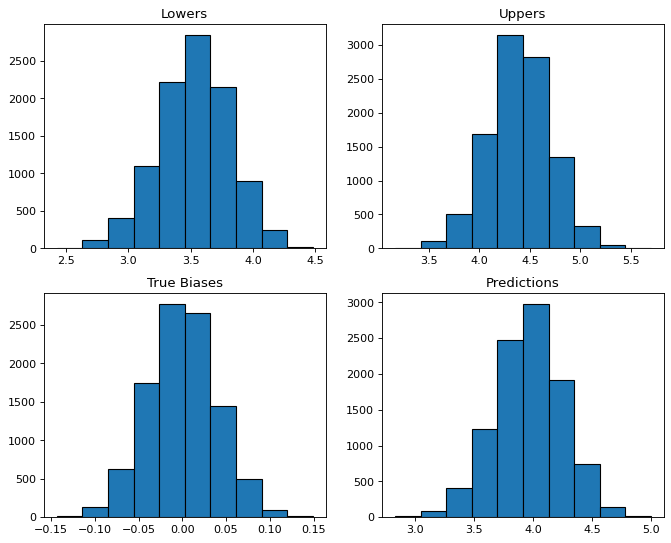

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=80)
axs[0, 0].hist(lowers, bins=10, edgecolor='black')
axs[0, 1].hist(uppers, bins=10, edgecolor='black')
axs[1, 0].hist(true_bias, bins=10, edgecolor='black')
axs[1, 1].hist(preds, bins=10, edgecolor='black')

axs[0, 0].set_title('Lowers')
axs[0, 1].set_title('Uppers')
axs[1, 0].set_title('True Biases')
axs[1, 1].set_title('Predictions')

In [29]:
# Naive imputation

# PPI Testing, experiment 0, multi-test

preds = []
lowers = []
uppers = []
true_bias = []
covered = []

# Generate training set
# Parameters

# Gamma dist, note the parameter names are not usual, k, theta is more usual

alpha = 1.0
beta = 2.0

# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho = 0.9 # 0 < rho <= 1 the smaller the rho, the more noise

# Iterations

n_its = 10000

for i in range(n_its):
    # Sampling

    x_train, y_train = sample_gamma_population(alpha, beta, train_sample, m, rho)  

    x_gold, y_gold = sample_gamma_population(alpha, beta, small_sample, m, rho)

    x_ppi, y_ppi = sample_gamma_population(alpha, beta, large_sample, m, rho)

    # Reshaping for scikitlearn

    x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
    x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
    x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

    model = build_fit_slr(x_train, y_train)  # Training

    y_fitted = model.predict(x_ppi)  # Unlabelled fitted

    # Naive imputation
    concat = np.vstack((y_gold, y_fitted)).flatten()  # Concactenate samples
    theta = np.mean(concat)  # Compute mean
    sigma = np.std(concat)  # Compute std dev
    n = concat.shape[0]
    theta_ci = stats.norm.interval(0.95, loc=theta, scale=sigma/np.sqrt(n))  # Use norm as N is large

    preds.append(theta)
    lowers.append(theta_ci[0])
    uppers.append(theta_ci[1])
    if true_mean >= theta_ci[0] and true_mean <= theta_ci[1]:
        covered.append(1)
    else:
        covered.append(0)

print("Average pred: ", np.mean(preds), "Average lower bound: ", np.mean(lowers), "Average upper bound: ", np.mean(uppers), "Covered percent: ", np.mean(covered))

Average pred:  3.9996379962025332 Average lower bound:  3.921486538503482 Average upper bound:  4.077789453901584 Covered percent:  0.8988


In [30]:
# Classical code

# Naive imputation

# PPI Testing, experiment 0, multi-test

preds = []
lowers = []
uppers = []
true_bias = []
covered = []

# Generate training set
# Parameters

# Gamma dist, note the parameter names are not usual, k, theta is more usual

alpha = 1.0
beta = 2.0

# Population samples

small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho = 0.9 # 0 < rho <= 1 the smaller the rho, the more noise

# Iterations

n_its = 10000

for i in range(n_its):
    x_gold, y_gold = sample_gamma_population(alpha, beta, small_sample, m, rho)  

    y_gold = np.array(y_gold).flatten()

    theta, se = np.mean(y_gold), stats.sem(y_gold)
    h = se * stats.t.ppf((1 + .95) / 2., n-1)  # Highly stolen code, uses t-dist here

    preds.append(theta)
    lowers.append(theta - h)
    uppers.append(theta + h)
    if true_mean >= theta - h and true_mean <= theta + h:
        covered.append(1)
    else:
        covered.append(0)


print("Average pred: ", np.mean(preds), "Average lower bound: ", np.mean(lowers), "Average upper bound: ", np.mean(uppers), "Covered percent: ", np.mean(covered))

Average pred:  3.9996319266000837 Average lower bound:  3.0747422169588186 Average upper bound:  4.924521636241349 Covered percent:  0.9359


Eventually I will combine the code into 1 for a single test, that's on the TODO list. But for now, we have reported 4 metrics with 10 thousand iterations. This is an example where rho is relatively small, in this case, the data is actually quite nice, and the model should fit very nicely, so we should expect every method to test well. Here are a summary of the results:


Classical always contained the train mean, and the the predicted mean even with 100 samples, was enough. With a t distribution confidence interval, we are able to contain the true parameter 100% of the time. The average confidence interval however, is quite large. This is to be expected with a small sample. 

Naive imputation actually performed the best, here because the model performs really well and the model is really simple (I think?). 

PPI kind of gets the best of both worlds. 

I'll finish writing this up later.

In [31]:
# Full experiment

# Gamma dist, note the parameter names are not usual, k, theta is more usual

alpha = 1.0
beta = 2.0

# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho_vals = [0.1, 0.5, 0.75, 0.90]

# Iterations

n_its = 10000

for r in rho_vals:
    rho = r

    ppi_preds = []
    ppi_lowers = []
    ppi_uppers = []
    ppi_true_bias = []
    ppi_covered = []
    ppi_widths = []

    naive_preds = []
    naive_lowers = []
    naive_uppers = []
    naive_covered = []
    naive_widths = []

    classical_preds = []
    classical_lowers = []
    classical_uppers = []
    classical_covered = []
    classical_widths = []

    residuals = []
    for i in range(n_its):
        # Sampling

        x_train, y_train = sample_gamma_population(alpha, beta, train_sample, m, rho) 

        x_gold, y_gold = sample_gamma_population(alpha, beta, small_sample, m, rho)

        x_ppi, y_ppi = sample_gamma_population(alpha, beta, large_sample, m, rho)

        # Reshaping for scikitlearn

        x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
        x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
        x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

        model = build_fit_slr(x_train, y_train)  # Training

        # Residual testing

        y_test_pred = model.predict(x_test)
        residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
        residuals.append(residual)

        y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
        y_fitted = model.predict(x_ppi)  # Unlabelled fitted

        # Manual rectifier computation
        rectifier = np.mean(y_gold_fitted - y_gold)

        # PPI section 

        ppi_theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
        ppi_theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


        ppi_preds.append(ppi_theta[0])
        ppi_lowers.append(ppi_theta_ci[0][0])
        ppi_uppers.append(ppi_theta_ci[1][0])
        ppi_true_bias.append(np.mean(y_fitted - y_ppi))
        if true_mean >= ppi_theta_ci[0][0] and true_mean <= ppi_theta_ci[1][0]:
            ppi_covered.append(1)
        else:
            ppi_covered.append(0)
        ppi_widths.append(ppi_theta_ci[1][0] - ppi_theta_ci[0][0])

        # Naive imputation
        concat = np.vstack((y_gold, y_fitted)).flatten()  # Concactenate samples
        naive_theta = np.mean(concat)  # Compute mean
        naive_sigma = np.std(concat)  # Compute std dev
        n_tot = concat.shape[0]
        naive_theta_ci = stats.norm.interval(0.9, loc=naive_theta, scale=naive_sigma/np.sqrt(n_tot))  # Use norm as N is large

        naive_preds.append(naive_theta)
        naive_lowers.append(naive_theta_ci[0])
        naive_uppers.append(naive_theta_ci[1])
        if true_mean >= naive_theta_ci[0] and true_mean <= naive_theta_ci[1]:
            naive_covered.append(1)
        else:
            naive_covered.append(0)
        naive_widths.append(naive_theta_ci[1] - naive_theta_ci[0])

        # Classical prediction (Gold standard only)
        
        classical_theta, classical_se = np.mean(y_gold.flatten()), stats.sem(y_gold.flatten())
        h = classical_se * stats.t.ppf((1 + .9) / 2., small_sample-1)  # Highly stolen code, uses t-dist here

        classical_preds.append(classical_theta)
        classical_lowers.append(classical_theta - h)
        classical_uppers.append(classical_theta + h)
        if true_mean >= classical_theta - h and true_mean <= classical_theta + h:
            classical_covered.append(1)
        else:
            classical_covered.append(0)
        classical_widths.append(2 * h)

    print("Rho: ", rho)
    print("Average residual: ", np.mean(residuals))
    print("PPI.", "Average pred: ", np.mean(ppi_preds), "Average lower bound: ", np.mean(
        ppi_lowers), "Average upper bound: ", np.mean(ppi_uppers), "Average width: ", np.mean(ppi_widths), "Covered percent: ", np.mean(ppi_covered))
    print("Naive.", "Average pred: ", np.mean(naive_preds), "Average lower bound: ", np.mean(
        naive_lowers), "Average upper bound: ", np.mean(naive_uppers), "Average width: ", np.mean(naive_widths), "Covered percent: ", np.mean(naive_covered))
    print("Classical.",  "Average pred: ", np.mean(classical_preds), "Average lower bound: ", np.mean(
        classical_lowers), "Average upper bound: ", np.mean(classical_uppers), "Average width: ", np.mean(classical_widths), "Covered percent: ", np.mean(classical_covered))

Rho:  0.1
Average residual:  1120.0124272628977
PPI. Average pred:  4.724759200820065 Average lower bound:  -174.6614156309732 Average upper bound:  184.11093403261336 Average width:  358.7723496635866 Covered percent:  0.8885
Naive. Average pred:  4.013548127634167 Average lower bound:  2.145107104990237 Average upper bound:  5.881989150278098 Average width:  3.7368820452878606 Covered percent:  0.1158
Classical. Average pred:  4.7469853987178325 Average lower bound:  -175.93812333223718 Average upper bound:  185.43209412967286 Average width:  361.37021746191 Covered percent:  0.8923
Rho:  0.5
Average residual:  33.908459078422986
PPI. Average pred:  4.024070982720037 Average lower bound:  -1.3793638854190744 Average upper bound:  9.427505850859148 Average width:  10.806869736278221 Covered percent:  0.885
Naive. Average pred:  4.0023975462250645 Average lower bound:  3.916276686445345 Average upper bound:  4.088518406004785 Average width:  0.1722417195594403 Covered percent:  0.1797


The better the residuals, aka the better the model fit, the better the CI's, sounds about right. In general, PPI outperforms classical, as we expected, when the model performs well. But it also performs about just as well, even when the model doesn't perform well. Don't use Naive, it's actually fake, unless the data is super super nice. But let's be honest here, real data is never nice.

In [34]:
# Experiment 1, different distribution, simplest setting, univariate

# Gamma dist, note the parameter names are not usual, k, theta is more usual

# Training distribution

alpha_1 = 1.0 
beta_1 = 2.0

# PPI distribution

alpha_2 = 3.0
beta_2 = 4.5

# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho_vals = [0.1, 0.5, 0.75, 0.90]

# Iterations

n_its = 10000

true_mean = m * alpha_2 * beta_2

for r in rho_vals:
    rho = r

    ppi_preds = []
    ppi_lowers = []
    ppi_uppers = []
    ppi_true_bias = []
    ppi_covered = []
    ppi_widths = []

    naive_preds = []
    naive_lowers = []
    naive_uppers = []
    naive_covered = []
    naive_widths = []

    classical_preds = []
    classical_lowers = []
    classical_uppers = []
    classical_covered = []
    classical_widths = []

    residuals = []
    biases =[]
    for i in range(n_its):
        # Sampling

        x_train, y_train = sample_gamma_population(alpha_1, beta_1, train_sample, m, rho) 

        x_gold, y_gold = sample_gamma_population(alpha_2, beta_2, small_sample, m, rho)

        x_ppi, y_ppi = sample_gamma_population(alpha_2, beta_2, large_sample, m, rho)

        # Reshaping for scikitlearn

        x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
        x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
        x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

        model = build_fit_slr(x_train, y_train)  # Training

        # Residual testing

        y_test_pred = model.predict(x_test)
        residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
        residuals.append(residual)

        y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
        y_fitted = model.predict(x_ppi)  # Unlabelled fitted

        # Manual rectifier computation
        rectifier = np.mean(y_gold_fitted - y_gold)

        # PPI section 

        ppi_theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
        ppi_theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


        ppi_preds.append(ppi_theta[0])
        ppi_lowers.append(ppi_theta_ci[0][0])
        ppi_uppers.append(ppi_theta_ci[1][0])
        ppi_true_bias.append(np.mean(y_fitted - y_ppi))
        if true_mean >= ppi_theta_ci[0][0] and true_mean <= ppi_theta_ci[1][0]:
            ppi_covered.append(1)
        else:
            ppi_covered.append(0)
        ppi_widths.append(ppi_theta_ci[1][0] - ppi_theta_ci[0][0])
        biases.append(np.mean(y_fitted - y_ppi))

        # Naive imputation
        concat = np.vstack((y_gold, y_fitted)).flatten()  # Concactenate samples
        naive_theta = np.mean(concat)  # Compute mean
        naive_sigma = np.std(concat)  # Compute std dev
        n_tot = concat.shape[0]
        naive_theta_ci = stats.norm.interval(0.9, loc=naive_theta, scale=naive_sigma/np.sqrt(n_tot))  # Use norm as N is large

        naive_preds.append(naive_theta)
        naive_lowers.append(naive_theta_ci[0])
        naive_uppers.append(naive_theta_ci[1])
        if true_mean >= naive_theta_ci[0] and true_mean <= naive_theta_ci[1]:
            naive_covered.append(1)
        else:
            naive_covered.append(0)
        naive_widths.append(naive_theta_ci[1] - naive_theta_ci[0])

        # Classical prediction (Gold standard only)
        
        classical_theta, classical_se = np.mean(y_gold.flatten()), stats.sem(y_gold.flatten())
        h = classical_se * stats.t.ppf((1 + .9) / 2., small_sample-1)  # Highly stolen code, uses t-dist here

        classical_preds.append(classical_theta)
        classical_lowers.append(classical_theta - h)
        classical_uppers.append(classical_theta + h)
        if true_mean >= classical_theta - h and true_mean <= classical_theta + h:
            classical_covered.append(1)
        else:
            classical_covered.append(0)
        classical_widths.append(2 * h)

    print("Rho: ", rho)
    print("Average residual: ", np.mean(residuals), "True bias :", np.mean(biases))
    print("PPI.", "Average pred: ", np.mean(ppi_preds), "Average lower bound: ", np.mean(
        ppi_lowers), "Average upper bound: ", np.mean(ppi_uppers), "Average width: ", np.mean(ppi_widths), "Covered percent: ", np.mean(ppi_covered))
    print("Naive.", "Average pred: ", np.mean(naive_preds), "Average lower bound: ", np.mean(
        naive_lowers), "Average upper bound: ", np.mean(naive_uppers), "Average width: ", np.mean(naive_widths), "Covered percent: ", np.mean(naive_covered))
    print("Classical.",  "Average pred: ", np.mean(classical_preds), "Average lower bound: ", np.mean(
        classical_lowers), "Average upper bound: ", np.mean(classical_uppers), "Average width: ", np.mean(classical_widths), "Covered percent: ", np.mean(classical_covered))

Rho:  0.1
Average residual:  1119.2643817588093 True bias : 0.19194971864407553
PPI. Average pred:  8.465494661759521 Average lower bound:  -481.4261501203081 Average upper bound:  498.35713944382707 Average width:  979.7832895641351 Covered percent:  0.8956
Naive. Average pred:  10.093963713776224 Average lower bound:  5.120261752403196 Average upper bound:  15.067665675149247 Average width:  9.947403922746052 Covered percent:  0.0708
Classical. Average pred:  8.438381557674843 Average lower bound:  -489.12560441546805 Average upper bound:  506.0023675308177 Average width:  995.1279719462857 Covered percent:  0.9004
Rho:  0.5
Average residual:  33.893746903088406 True bias : -0.046307273703137974
PPI. Average pred:  9.89309752995073 Average lower bound:  -4.899462200157798 Average upper bound:  24.68565726005926 Average width:  29.585119460217054 Covered percent:  0.8931
Naive. Average pred:  9.971733821287165 Average lower bound:  9.782428551644625 Average upper bound:  10.1610390909

Performs better than classical with data drift.

In [76]:
# Experiment 1, different distribution, simplest setting, univariate

# Gamma dist, note the parameter names are not usual, k, theta is more usual

# Training distribution

alpha_1 = 1.0 
beta_1 = 2.0


# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho = 0.75

second_pop_params = [(3.0, 4.5), (10.0, 17.0), (50.0, 80.0), (100.0, 400.0)]

# Iterations

n_its = 10000

for params in second_pop_params:
    alpha_2, beta_2 = params
    true_mean = m * alpha_2 * beta_2

    ppi_preds = []
    ppi_lowers = []
    ppi_uppers = []
    ppi_true_bias = []
    ppi_covered = []
    ppi_widths = []

    naive_preds = []
    naive_lowers = []
    naive_uppers = []
    naive_covered = []
    naive_widths = []

    classical_preds = []
    classical_lowers = []
    classical_uppers = []
    classical_covered = []
    classical_widths = []

    residuals = []
    biases =[]
    for i in range(n_its):
        # Sampling

        x_train, y_train = sample_gamma_population(alpha_1, beta_1, train_sample, m, rho) 

        x_gold, y_gold = sample_gamma_population(alpha_2, beta_2, small_sample, m, rho)

        x_ppi, y_ppi = sample_gamma_population(alpha_2, beta_2, large_sample, m, rho)

        # Reshaping for scikitlearn

        x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
        x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
        x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

        model = build_fit_slr(x_train, y_train)  # Training

        # Residual testing

        y_test_pred = model.predict(x_test)
        residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
        residuals.append(residual)

        y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
        y_fitted = model.predict(x_ppi)  # Unlabelled fitted

        # Manual rectifier computation
        rectifier = np.mean(y_gold_fitted - y_gold)

        # PPI section 

        ppi_theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
        ppi_theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


        ppi_preds.append(ppi_theta[0])
        ppi_lowers.append(ppi_theta_ci[0][0])
        ppi_uppers.append(ppi_theta_ci[1][0])
        ppi_true_bias.append(np.mean(y_fitted - y_ppi))
        if true_mean >= ppi_theta_ci[0][0] and true_mean <= ppi_theta_ci[1][0]:
            ppi_covered.append(1)
        else:
            ppi_covered.append(0)
        ppi_widths.append(ppi_theta_ci[1][0] - ppi_theta_ci[0][0])
        biases.append(np.mean(y_fitted - y_ppi))

        # Naive imputation
        concat = np.vstack((y_gold, y_fitted)).flatten()  # Concactenate samples
        naive_theta = np.mean(concat)  # Compute mean
        naive_sigma = np.std(concat)  # Compute std dev
        n_tot = concat.shape[0]
        naive_theta_ci = stats.norm.interval(0.9, loc=naive_theta, scale=naive_sigma/np.sqrt(n_tot))  # Use norm as N is large

        naive_preds.append(naive_theta)
        naive_lowers.append(naive_theta_ci[0])
        naive_uppers.append(naive_theta_ci[1])
        if true_mean >= naive_theta_ci[0] and true_mean <= naive_theta_ci[1]:
            naive_covered.append(1)
        else:
            naive_covered.append(0)
        naive_widths.append(naive_theta_ci[1] - naive_theta_ci[0])

        # Classical prediction (Gold standard only)
        
        classical_theta, classical_se = np.mean(y_gold.flatten()), stats.sem(y_gold.flatten())
        h = classical_se * stats.t.ppf((1 + .9) / 2., small_sample-1)  # Highly stolen code, uses t-dist here

        classical_preds.append(classical_theta)
        classical_lowers.append(classical_theta - h)
        classical_uppers.append(classical_theta + h)
        if true_mean >= classical_theta - h and true_mean <= classical_theta + h:
            classical_covered.append(1)
        else:
            classical_covered.append(0)
        classical_widths.append(2 * h)

    print("Rho: ", rho)
    print("Average residual: ", np.mean(residuals), "True bias :", np.mean(biases))
    print("PPI.", "Average pred: ", np.mean(ppi_preds), "Average lower bound: ", np.mean(
        ppi_lowers), "Average upper bound: ", np.mean(ppi_uppers), "Average width: ", np.mean(ppi_widths), "Covered percent: ", np.mean(ppi_covered))
    print("Naive.", "Average pred: ", np.mean(naive_preds), "Average lower bound: ", np.mean(
        naive_lowers), "Average upper bound: ", np.mean(naive_uppers), "Average width: ", np.mean(naive_widths), "Covered percent: ", np.mean(naive_covered))
    print("Classical.",  "Average pred: ", np.mean(classical_preds), "Average lower bound: ", np.mean(
        classical_lowers), "Average upper bound: ", np.mean(classical_uppers), "Average width: ", np.mean(classical_widths), "Covered percent: ", np.mean(classical_covered))

Rho:  0.75
Average residual:  8.793007561974562 True bias : 0.020487884857468105
PPI. Average pred:  26.745535268279024 Average lower bound:  9.100625186359203 Average upper bound:  44.390445350198846 Average width:  35.28982016383964 Covered percent:  0.8852
Naive. Average pred:  27.01767050950924 Average lower bound:  26.706644186774078 Average upper bound:  27.3286968322444 Average width:  0.6220526454703263 Covered percent:  0.1593
Classical. Average pred:  26.79076141599653 Average lower bound:  8.61622224198958 Average upper bound:  44.96530059000347 Average width:  36.3490783480139 Covered percent:  0.8945
Rho:  0.75
Average residual:  8.796107508174758 True bias : -0.9112728815114768
PPI. Average pred:  333.0894895292189 Average lower bound:  -435.15158013364226 Average upper bound:  1101.33055919208 Average width:  1536.482139325722 Covered percent:  0.8967
Naive. Average pred:  339.8634053875361 Average lower bound:  332.0096526050472 Average upper bound:  347.71715817002485 

In [79]:
def sample_mv_y_linear(x, vec, beta, rho):
    sigma_squared = abs(m)*beta*(1.-(rho**2))/(rho**2)

    # sample noise (e_i)
    sampled_e = np.random.normal(loc=0,
                                 scale=sigma_squared,
                                 size=(x.shape[0], 1)
                                 )

    # compute y as a linear function of x
    y = x @ vec + sampled_e

    return y

def sample_mv_gamma_population(alpha, beta, sample_size, vec, rho=None):
    assert np.any(rho != 0), "rho must be different from 0"

    # sample x
    x = np.random.gamma(alpha, beta, (sample_size, vec.shape[0]))
    # sample y
    y = sample_mv_y_linear(x, vec, beta, rho)

    return x, y

In [71]:
# Create and fix a random vector
dims = 10
vec = np.random.uniform(low=-3, high=3, size=dims).reshape(-1, 1)
print(vec)

[[ 1.37367737]
 [-1.7810618 ]
 [ 0.50282874]
 [ 0.41660295]
 [ 1.20293366]
 [ 0.17196751]
 [ 2.22924012]
 [ 1.98606939]
 [ 1.17205473]
 [ 1.66227883]]


In [77]:
# Experiment 1, different distribution, simplest setting, multivariate

# Gamma dist, note the parameter names are not usual, k, theta is more usual

# Training distribution

alpha_1 = 1.0 
beta_1 = 2.0


# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

vec = vec  # Don't ask why, this is just from the previous block
rho = 0.75

second_pop_params = [(3.0, 4.5), (10.0, 17.0), (50.0, 80.0), (100.0, 400.0)]

# Iterations

n_its = 1000

for params in second_pop_params:
    alpha_1, beta_2 = params

    ppi_preds = []
    ppi_lowers = []
    ppi_uppers = []
    ppi_true_bias = []
    ppi_covered = []
    ppi_widths = []

    naive_preds = []
    naive_lowers = []
    naive_uppers = []
    naive_covered = []
    naive_widths = []

    classical_preds = []
    classical_lowers = []
    classical_uppers = []
    classical_covered = []
    classical_widths = []

    residuals = []
    biases = []

    true_mean = alpha_2 * beta_2 * np.sum(vec)
    for i in range(n_its):
        # Sampling

        x_train, y_train = sample_mv_gamma_population(alpha_1, beta_1, train_sample, vec, rho) 

        x_gold, y_gold = sample_mv_gamma_population(alpha_2, beta_2, small_sample, vec, rho)

        x_ppi, y_ppi = sample_mv_gamma_population(alpha_2, beta_2, large_sample, vec, rho)


        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

        model = build_fit_slr(x_train, y_train)  # Training

        # Residual testing

        y_test_pred = model.predict(x_test)
        residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
        residuals.append(residual)

        y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
        y_fitted = model.predict(x_ppi)  # Unlabelled fitted

        # Manual rectifier computation
        rectifier = np.mean(y_gold_fitted - y_gold)

        # PPI section 

        ppi_theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
        ppi_theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


        ppi_preds.append(ppi_theta[0])
        ppi_lowers.append(ppi_theta_ci[0][0])
        ppi_uppers.append(ppi_theta_ci[1][0])
        ppi_true_bias.append(np.mean(y_fitted - y_ppi))
        if true_mean >= ppi_theta_ci[0][0] and true_mean <= ppi_theta_ci[1][0]:
            ppi_covered.append(1)
        else:
            ppi_covered.append(0)
        ppi_widths.append(ppi_theta_ci[1][0] - ppi_theta_ci[0][0])
        biases.append(np.mean(y_fitted - y_ppi))

        # Naive imputation
        concat = np.vstack((y_gold, y_fitted)).flatten()  # Concactenate samples
        naive_theta = np.mean(concat)  # Compute mean
        naive_sigma = np.std(concat)  # Compute std dev
        n_tot = concat.shape[0]
        naive_theta_ci = stats.norm.interval(0.9, loc=naive_theta, scale=naive_sigma/np.sqrt(n_tot))  # Use norm as N is large

        naive_preds.append(naive_theta)
        naive_lowers.append(naive_theta_ci[0])
        naive_uppers.append(naive_theta_ci[1])
        if true_mean >= naive_theta_ci[0] and true_mean <= naive_theta_ci[1]:
            naive_covered.append(1)
        else:
            naive_covered.append(0)
        naive_widths.append(naive_theta_ci[1] - naive_theta_ci[0])

        # Classical prediction (Gold standard only)
        
        classical_theta, classical_se = np.mean(y_gold.flatten()), stats.sem(y_gold.flatten())
        h = classical_se * stats.t.ppf((1 + .9) / 2., small_sample-1)  # Highly stolen code, uses t-dist here

        classical_preds.append(classical_theta)
        classical_lowers.append(classical_theta - h)
        classical_uppers.append(classical_theta + h)
        if true_mean >= classical_theta - h and true_mean <= classical_theta + h:
            classical_covered.append(1)
        else:
            classical_covered.append(0)
        classical_widths.append(2 * h)

    print("Rho: ", rho)
    print("Average residual: ", np.mean(residuals), "True bias :", np.mean(biases))
    print("PPI.", "Average pred: ", np.mean(ppi_preds), "Average lower bound: ", np.mean(
        ppi_lowers), "Average upper bound: ", np.mean(ppi_uppers), "Average width: ", np.mean(ppi_widths), "Covered percent: ", np.mean(ppi_covered))
    print("Naive.", "Average pred: ", np.mean(naive_preds), "Average lower bound: ", np.mean(
        naive_lowers), "Average upper bound: ", np.mean(naive_uppers), "Average width: ", np.mean(naive_widths), "Covered percent: ", np.mean(naive_covered))
    print("Classical.",  "Average pred: ", np.mean(classical_preds), "Average lower bound: ", np.mean(
        classical_lowers), "Average upper bound: ", np.mean(classical_uppers), "Average width: ", np.mean(classical_widths), "Covered percent: ", np.mean(classical_covered))

Rho:  0.75
Average residual:  3.1109453479198548 True bias : -0.41108534915424416
PPI. Average pred:  4021.4301139230333 Average lower bound:  4017.0945891062906 Average upper bound:  4025.765638739777 Average width:  8.671049633486637 Covered percent:  0.888
Naive. Average pred:  4021.0839645203723 Average lower bound:  4017.790818347135 Average upper bound:  4024.37711069361 Average width:  6.586292346475028 Covered percent:  0.198
Classical. Average pred:  4022.233358138044 Average lower bound:  3988.8500728633867 Average upper bound:  4055.616643412701 Average width:  66.76657054931411 Covered percent:  0.879
Rho:  0.75
Average residual:  3.1115515773237976 True bias : 0.6603072964962597
PPI. Average pred:  15191.524050429327 Average lower bound:  15175.024496197373 Average upper bound:  15208.023604661279 Average width:  32.99910846390546 Covered percent:  0.906
Naive. Average pred:  15192.536891674996 Average lower bound:  15180.09039120113 Average upper bound:  15204.98339214885

Honestly about the same, except that when data becomes really deviated from the training data, PPI performs MUCH better than classical. Imputed still sucks and is unreliable, at least, until it's forced to give out really wide confidence intervals as well.

In [42]:
alpha = 1
beta = 1
sample_size = 10
x = np.random.gamma(alpha, beta, (50, 10))
x.shape

(50, 10)

In [106]:
def sample_mv_norm_gamma_population(alpha, beta, sample_size, vec):
    # sample x
    x = np.random.gamma(alpha, beta, (sample_size, vec.shape[0]))
    # sample y
    y = ((np.linalg.norm(x, axis=1)**2)/vec.shape[0]).reshape(-1,1)

    return x, y

In [113]:
# Experiment 1, different distribution, simplest setting, multivariate

# HORRENDOUSLY SLOW, PROCEED WITH CAUTION WHEN INCREASING N_ITS

# Gamma dist, note the parameter names are not usual, k, theta is more usual

# Training distribution

alpha_1 = 1.0 
beta_1 = 2.0


# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

vec = vec  # Don't ask why, this is just from the previous block
rho = 0.75

second_pop_params = [(3.0, 4.5), (10.0, 17.0), (50.0, 80.0), (100.0, 400.0)]

# Iterations

n_its = 10

for params in second_pop_params:
    alpha_1, beta_2 = params

    ppi_preds = []
    ppi_lowers = []
    ppi_uppers = []
    ppi_true_bias = []
    ppi_covered = []
    ppi_widths = []

    naive_preds = []
    naive_lowers = []
    naive_uppers = []
    naive_covered = []
    naive_widths = []

    classical_preds = []
    classical_lowers = []
    classical_uppers = []
    classical_covered = []
    classical_widths = []

    residuals = []
    biases = []

    true_mean = beta_2**2 * alpha_2 * (alpha_2 + 1)
    for i in range(n_its):
        # Sampling

        x_train, y_train = sample_mv_norm_gamma_population(alpha_1, beta_1, train_sample, vec) 

        x_gold, y_gold = sample_mv_norm_gamma_population(alpha_2, beta_2, small_sample, vec)

        x_ppi, y_ppi = sample_mv_norm_gamma_population(alpha_2, beta_2, large_sample, vec)


        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

        y_train, y_test = y_train.flatten(), y_test.flatten()

        model = build_fit_rf(x_train, y_train)  # Training

        # Residual testing

        y_test_pred = model.predict(x_test)
        residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
        residuals.append(residual)

        y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
        y_fitted = model.predict(x_ppi)  # Unlabelled fitted

        # Manual rectifier computation
        rectifier = np.mean(y_gold_fitted - y_gold)

        # PPI section 

        ppi_theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted, lhat=1)
        ppi_theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted, lhat=1)


        ppi_preds.append(ppi_theta[0])
        ppi_lowers.append(ppi_theta_ci[0][0])
        ppi_uppers.append(ppi_theta_ci[1][0])
        ppi_true_bias.append(np.mean(y_fitted - y_ppi))
        if true_mean >= ppi_theta_ci[0][0] and true_mean <= ppi_theta_ci[1][0]:
            ppi_covered.append(1)
        else:
            ppi_covered.append(0)
        ppi_widths.append(ppi_theta_ci[1][0] - ppi_theta_ci[0][0])
        biases.append(np.mean(y_fitted - y_ppi))


        # Naive imputation
        concat = np.vstack((y_gold, y_fitted.reshape(-1,1))).flatten()  # Concactenate samples
        naive_theta = np.mean(concat)  # Compute mean
        naive_sigma = np.std(concat)  # Compute std dev
        n_tot = concat.shape[0]
        naive_theta_ci = stats.norm.interval(0.9, loc=naive_theta, scale=naive_sigma/np.sqrt(n_tot))  # Use norm as N is large

        naive_preds.append(naive_theta)
        naive_lowers.append(naive_theta_ci[0])
        naive_uppers.append(naive_theta_ci[1])
        if true_mean >= naive_theta_ci[0] and true_mean <= naive_theta_ci[1]:
            naive_covered.append(1)
        else:
            naive_covered.append(0)
        naive_widths.append(naive_theta_ci[1] - naive_theta_ci[0])


        # Classical prediction (Gold standard only)
        
        classical_theta, classical_se = np.mean(y_gold.flatten()), stats.sem(y_gold.flatten())
        h = classical_se * stats.t.ppf((1 + .9) / 2., small_sample-1)  # Highly stolen code, uses t-dist here

        classical_preds.append(classical_theta)
        classical_lowers.append(classical_theta - h)
        classical_uppers.append(classical_theta + h)
        if true_mean >= classical_theta - h and true_mean <= classical_theta + h:
            classical_covered.append(1)
        else:
            classical_covered.append(0)
        classical_widths.append(2 * h)

    print("Rho: ", rho)
    print("Average residual: ", np.mean(residuals), "True bias :", np.mean(biases))
    print("PPI.", "Average pred: ", np.mean(ppi_preds), "Average lower bound: ", np.mean(
        ppi_lowers), "Average upper bound: ", np.mean(ppi_uppers), "Average width: ", np.mean(ppi_widths), "Covered percent: ", np.mean(ppi_covered))
    print("Naive.", "Average pred: ", np.mean(naive_preds), "Average lower bound: ", np.mean(
        naive_lowers), "Average upper bound: ", np.mean(naive_uppers), "Average width: ", np.mean(naive_widths), "Covered percent: ", np.mean(naive_covered))
    print("Classical.",  "Average pred: ", np.mean(classical_preds), "Average lower bound: ", np.mean(
        classical_lowers), "Average upper bound: ", np.mean(classical_uppers), "Average width: ", np.mean(classical_widths), "Covered percent: ", np.mean(classical_covered))

Rho:  0.75
Average residual:  6.343296357888015 True bias : -204415.76712452364
PPI. Average pred:  204834.68425495573 Average lower bound:  202680.88291265542 Average upper bound:  206988.4855972561 Average width:  4307.60268460071 Covered percent:  1.0
Naive. Average pred:  2157.9075042114005 Average lower bound:  1825.4990883925043 Average upper bound:  2490.3159200302957 Average width:  664.8168316377918 Covered percent:  0.0
Classical. Average pred:  204834.68425495576 Average lower bound:  202649.5848404662 Average upper bound:  207019.78366944529 Average width:  4370.198828979081 Covered percent:  1.0
Rho:  0.75
Average residual:  34.34568413560489 True bias : -2917917.450684976
PPI. Average pred:  2911117.346288885 Average lower bound:  2881551.593335755 Average upper bound:  2940683.0992420157 Average width:  59131.50590626076 Covered percent:  0.9
Naive. Average pred:  29600.236422673603 Average lower bound:  24874.972218335784 Average upper bound:  34325.50062701142 Average 